# GP classification of botnet C&C communication

## Import and load data

In [3]:
import sys
sys.path.insert(0, '../')
import numpy as np
from jax.experimental import optimizers
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv, ListedColormap
import matplotlib as mpl
from scipy.interpolate import interp1d
import time
from sde_gp import SDEGP
import approximate_inference as approx_inf
import priors
import likelihoods
from utils import softplus_list, plot_2d_classification

mpl.rcParams['figure.figsize'] = (7, 7)

ModuleNotFoundError: No module named 'jaxlib'

In [2]:
import pandas as pd 

def get_ctu13(path):

    columns = ["start_time", "duration", "protocol",  "src_ip", 
               "src_port", "direction", "dst_ip", "dst_port", "state",
               "src_tos", "dst_tos", "total_packets", "total_bytes", "src_bytes", "label"]
    
    df = pd.read_csv(path, parse_dates=["start_time"], names=columns, skiprows=1)
    
    df = df.dropna(axis=0) # ports, tos, and states are sometimes unidentified => drop rows with missing values for these columns

    df.loc[df['label'].str.contains('Botnet'), 'label'] = 1 # malicious
    df.loc[df['label']!=1, 'label'] = 0 # benign

    return df

In [3]:
ctu13 = get_ctu13('../../data/capture20110810.binetflow')

In [4]:
ctu13['total_bytes'].describe()

count    2.619340e+06
mean     2.032101e+04
std      3.329857e+06
min      6.000000e+01
25%      2.140000e+02
50%      2.680000e+02
75%      6.120000e+02
max      2.689640e+09
Name: total_bytes, dtype: float64

In [5]:
cond = (ctu13['total_bytes']>100) &\
        (ctu13['total_bytes']<1000)
botnet = ctu13[cond & (ctu13['label']==1)].sample(100)
normal = ctu13[cond & (ctu13['label']==0)].sample(100)
sampled = pd.concat([botnet, normal])

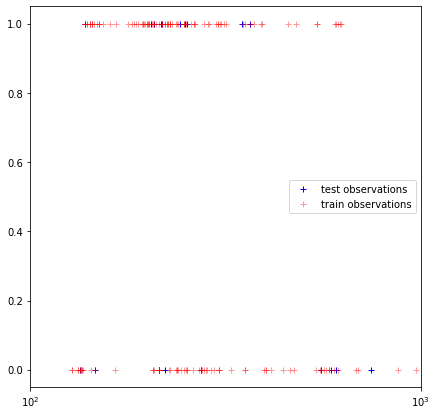

In [6]:
y_feature = 'label'
x_feature = 'total_bytes'

test_botnet = botnet.sample(10)
test_normal = normal.sample(10)
test_data = pd.concat([test_botnet, test_normal]).sample(frac=1.)

test_idx = sampled.index.isin(test_data.index)
train_data = sampled[~test_idx]

#plt.xlim(datetime.datetime(2011,8,10,11,0,0), datetime.datetime(2011,8,10,12,0,0));
plt.xlim(100, 1000);
plt.xscale('symlog')
plt.plot(test_data[x_feature], test_data[y_feature], 'b+', label='test observations');
plt.plot(train_data[x_feature], train_data[y_feature], 'r+',  alpha=0.4, label='train observations');
plt.legend();

In [7]:
test_data.shape

(20, 15)

In [8]:
train_data.shape

(180, 15)

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x = scaler.fit_transform(train_data['total_bytes'].astype('float').to_numpy().reshape(-1,1))
y = train_data['label'].astype('int').to_numpy()

x_test = scaler.transform(test_data['total_bytes'].astype('float').to_numpy().reshape(-1,1))
y_test = test_data['label'].astype('int').to_numpy()

In [21]:
x_test

array([[0.01187648],
       [0.50712589],
       [0.10213777],
       [0.56769596],
       [0.09501188],
       [0.10213777],
       [0.28266033],
       [0.11163895],
       [0.26247031],
       [0.13539192],
       [0.73159145],
       [0.14370546],
       [0.00712589],
       [0.54869359],
       [0.09026128],
       [0.14726841],
       [0.10688836],
       [0.17339667],
       [0.10451306],
       [0.02256532]])

## Build the GP model

In [22]:
var_f = 1.  # GP variance
len_f = 5.0  # GP lengthscale

prior = priors.Matern52(variance=var_f, lengthscale=len_f)

lik = likelihoods.Bernoulli(link='logit')
inf_method = approx_inf.ExpectationPropagation(power=0.9, intmethod='UT')

model = SDEGP(prior=prior, likelihood=lik, t=x, y=y, approx_inf=inf_method)

building SDE-GP with Matern-5/2 prior and Bernoulli likelihood ...
inference method is Expectation Propagation (EP)


## Set up the optimiser

In [23]:
opt_init, opt_update, get_params = optimizers.adam(step_size=2e-1)
# parameters should be a 2-element list [param_prior, param_likelihood]
opt_state = opt_init([model.prior.hyp, model.likelihood.hyp])

plot_intermediate = False
def gradient_step(i, state, mod):
    params = get_params(state)
    mod.prior.hyp = params[0]
    mod.likelihood.hyp = params[1]

    # grad(Filter) + Smoother:
    neg_log_marg_lik, gradients = mod.run()
    # neg_log_marg_lik, gradients = mod.run_two_stage()  # <-- less elegant but reduces compile time

    prior_params = softplus_list(params[0])
    if (i % 10) == 0:
        print('iter %2d: var_f=%1.2f len_f=%1.2f, nlml=%2.2f' %
              (i, prior_params[0], prior_params[1], neg_log_marg_lik))

    if plot_intermediate:
        plot(mod, i)

    return opt_update(i, gradients, state)

## Optimise the hyperparameters and site parameters

In [24]:
print('optimising the hyperparameters ...')
t0 = time.time()
for j in range(200):
    opt_state = gradient_step(j, opt_state, model)
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))

optimising the hyperparameters ...
iter  0: var_f=1.00 len_f=5.00, nlml=126.20
iter 10: var_f=1.88 len_f=3.01, nlml=126.12
iter 20: var_f=3.63 len_f=1.36, nlml=125.93
iter 30: var_f=4.19 len_f=2.01, nlml=125.86
iter 40: var_f=4.94 len_f=2.29, nlml=125.84
iter 50: var_f=5.92 len_f=2.11, nlml=125.84
iter 60: var_f=6.57 len_f=2.35, nlml=125.83
iter 70: var_f=7.19 len_f=2.50, nlml=125.82
iter 80: var_f=7.84 len_f=2.51, nlml=125.82
iter 90: var_f=8.41 len_f=2.62, nlml=125.81
iter 100: var_f=8.94 len_f=2.71, nlml=125.81
iter 110: var_f=9.47 len_f=2.76, nlml=125.81
iter 120: var_f=9.97 len_f=2.83, nlml=125.81
iter 130: var_f=10.45 len_f=2.90, nlml=125.80
iter 140: var_f=10.92 len_f=2.95, nlml=125.80
iter 150: var_f=11.37 len_f=3.01, nlml=125.80
iter 160: var_f=11.80 len_f=3.06, nlml=125.80
iter 170: var_f=12.23 len_f=3.11, nlml=125.80
iter 180: var_f=12.64 len_f=3.16, nlml=125.80
iter 190: var_f=13.04 len_f=3.21, nlml=125.79
optimisation time: 14.13 secs


## Make predictions

In [25]:
x_plot = np.linspace(np.min(x)-10.0, np.max(x)+10.0, num=500)
print('calculating the posterior predictive distribution ...')
t0 = time.time()
nlpd = model.negative_log_predictive_density(t=x_test, y=y_test)
posterior_mean, posterior_cov = model.predict(t=x_plot)
t1 = time.time()
print('prediction time: %2.2f secs' % (t1-t0))
print('test NLPD: %1.2f' % nlpd)

calculating the posterior predictive distribution ...
prediction time: 2.78 secs
test NLPD: 0.66


## Sample from the posterior distribution

In [26]:
print('sampling from the posterior ...')
t0 = time.time()
posterior_samp = model.posterior_sample(20, t=x_plot)
t1 = time.time()
print('sampling time: %2.2f secs' % (t1-t0))

sampling from the posterior ...
sampling time: 4.00 secs


## Plot posterior mean using colour map

plotting ...


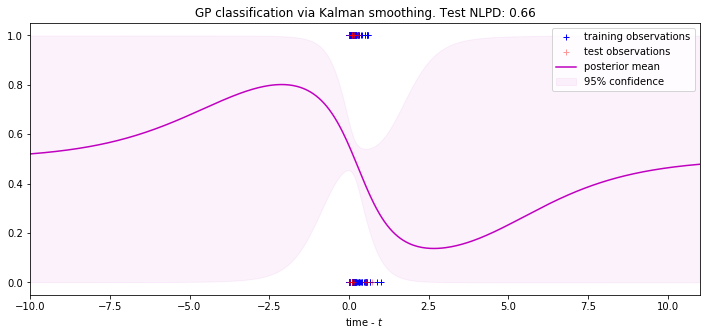

In [27]:
lb = posterior_mean - 1.96 * posterior_cov ** 0.5
ub = posterior_mean + 1.96 * posterior_cov ** 0.5
link_fn = model.likelihood.link_fn

print('plotting ...')
plt.figure(2, figsize=(12, 5))
plt.clf()
plt.plot(x, y, 'b+', label='training observations')
plt.plot(x_test, y_test, 'r+', alpha=0.4, label='test observations')
plt.plot(x_plot, link_fn(posterior_mean), 'm', label='posterior mean')
plt.fill_between(x_plot, link_fn(lb), link_fn(ub), color='m', alpha=0.05, label='95% confidence')
plt.plot(x_plot, link_fn(posterior_samp), 'm', alpha=0.15)
plt.xlim(x_plot[0], x_plot[-1])
plt.legend()
plt.title('GP classification via Kalman smoothing. Test NLPD: %1.2f' % nlpd)
plt.xlabel('time - $t$');